## Read dataset

In [15]:
# Cell 1: load data
from pathlib import Path
import pandas as pd


ROOT = Path.home() / "Desktop" / "COMP9417_Project"
DATA = ROOT / "preprocessing_output"

assert (DATA/"train_2004.csv").exists() and (DATA/"test_2005.csv").exists(), "缺少 train_2004.csv 或 test_2005.csv"

train = pd.read_csv(DATA/"train_2004.csv", parse_dates=["DateTime"]).sort_values("DateTime").reset_index(drop=True)
test  = pd.read_csv(DATA/"test_2005.csv",  parse_dates=["DateTime"]).sort_values("DateTime").reset_index(drop=True)

print("train/test shapes:", train.shape, test.shape)
train.head()

train/test shapes: (6578, 67) (2231, 67)


,DateTime,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),...,NOx_rolling_mean_12h,NOx_rolling_std_12h,NOx_rolling_mean_24h,NOx_rolling_std_24h,NO2_rolling_mean_6h,NO2_rolling_std_6h,NO2_rolling_mean_12h,NO2_rolling_std_12h,NO2_rolling_mean_24h,NO2_rolling_std_24h
0,2004-03-11 18:00:00,1.865461,2.188031,1.428114,1.415304,0.203281,-0.137257,0.872820,1.838560,0.920641,...,-0.453809,-0.514685,-0.797869,-0.567723,0.498420,-0.549244,0.108289,-0.460076,-0.466987,0.011314
1,2004-03-11 19:00:00,3.315827,3.080951,2.311259,2.047081,0.698232,-0.516040,1.316082,2.562365,1.642654,...,-0.310411,-0.218785,-0.719991,-0.351883,0.737332,-0.172254,0.313240,-0.224537,-0.362443,0.263652
2,2004-03-11 20:00:00,2.763306,2.458197,1.856306,1.733062,0.542953,-0.355936,1.168328,2.151244,1.520279,...,-0.221354,-0.065023,-0.658802,-0.223287,0.884661,-0.085718,0.433934,-0.033341,-0.295797,0.431723
3,2004-03-11 21:00:00,1.243875,0.960840,0.357635,0.506891,0.004331,0.479729,0.556205,0.749956,0.617151,...,-0.165505,-0.095440,-0.639889,-0.200529,0.924480,-0.220413,0.513637,-0.101135,-0.277502,0.463150
4,2004-03-11 22:00:00,-0.413686,-0.632678,-0.726225,-0.715541,-0.704127,1.916762,-0.520286,-0.332857,-0.518490,...,-0.174561,-0.071691,-0.650180,-0.194869,0.741314,0.806925,0.484033,0.005974,-0.318013,0.462190


## Public functions (RMSE, feature selection, supervised learning alignment)

In [17]:
# Cell 2: helpers
import numpy as np


def rmse(y, yhat):
    y = np.asarray(y, float); yhat = np.asarray(yhat, float)
    return float(np.sqrt(np.mean((y - yhat)**2)))


def pick_features(cols, mode="engineered"):
    cols = list(cols)
    base_keep = {
        "sensors": ['PT08.S1(CO)','PT08.S2(NMHC)','PT08.S3(NOx)','PT08.S4(NO2)','PT08.S5(O3)'],
        "weather": ['T','RH','AH'],
        "time": ['Hour','DayOfWeek','Month','Year','IsWeekend','DayOfYear','Hour_sin','Hour_cos','Month_sin','Month_cos'],
    }
    base = [c for g in base_keep.values() for c in g if c in cols]
    if mode == "raw":
        return base
    else:
        ban = set(['DateTime','CO(GT)','C6H6(GT)','NOx(GT)','NO2(GT)','NMHC(GT)'])
        return [c for c in cols if c not in ban]


def make_supervised(df, target, k, feature_cols):
    df = df.sort_values("DateTime").reset_index(drop=True).copy()
    
    y_future = df[target].shift(-k)
    X = df[feature_cols].copy()
   
    n = len(df) - k
    X = X.iloc[:n].reset_index(drop=True)
    y = y_future.iloc[:n].reset_index(drop=True)
    
    pred_time = df["DateTime"].iloc[:n].reset_index(drop=True)
    target_time = df["DateTime"].iloc[:n].add(pd.to_timedelta(k, unit="h")).reset_index(drop=True)
    return X, y, pred_time, target_time

## Baseline

In [23]:
# Cell 3: baseline (persistence)
from pathlib import Path

RES_DIR = ROOT / "models" / "regression" / "results"
PRED_DIR = ROOT / "models" / "regression" / "predictions"
RES_DIR.mkdir(parents=True, exist_ok=True)
PRED_DIR.mkdir(parents=True, exist_ok=True)

targets = ["CO(GT)", "C6H6(GT)", "NOx(GT)", "NO2(GT)"]
horizons = [1, 6, 12, 24]

rows = []
for tgt in targets:
    for k in horizons:
        df = test[["DateTime", tgt]].copy()
        df["y_pred"] = df[tgt]                         
        df["y_true"] = df[tgt].shift(-k)             
        df = df.iloc[:-k].reset_index(drop=True)      
        score = rmse(df["y_true"], df["y_pred"])
        rows.append({"pollutant": tgt, "horizon_h": k, "model": "baseline_persistence", "rmse": score})
        
        outp = PRED_DIR / f"pred_{tgt.replace('(GT)','').replace(' ','')}_{k}h_baseline.csv"
        df[["DateTime","y_true","y_pred"]].to_csv(outp, index=False)

baseline_df = pd.DataFrame(rows).sort_values(["pollutant","horizon_h"]).reset_index(drop=True)
baseline_csv = RES_DIR / "baseline_rmse_aligned.csv"
baseline_df.to_csv(baseline_csv, index=False)
print("saved:", baseline_csv)
print(baseline_df.to_string(index=False))

saved: /Users/zhangdonghuang/Desktop/COMP9417_Project/models/regression/results/baseline_rmse_aligned.csv
pollutant  horizon_h                model     rmse
 C6H6(GT)          1 baseline_persistence 0.484253
 C6H6(GT)          6 baseline_persistence 1.092493
 C6H6(GT)         12 baseline_persistence 1.129208
 C6H6(GT)         24 baseline_persistence 0.789835
   CO(GT)          1 baseline_persistence 0.536310
   CO(GT)          6 baseline_persistence 1.217734
   CO(GT)         12 baseline_persistence 1.215970
   CO(GT)         24 baseline_persistence 0.872932
  NO2(GT)          1 baseline_persistence 0.526849
  NO2(GT)          6 baseline_persistence 1.445019
  NO2(GT)         12 baseline_persistence 1.438931
  NO2(GT)         24 baseline_persistence 0.943311
  NOx(GT)          1 baseline_persistence 0.532539
  NOx(GT)          6 baseline_persistence 1.324477
  NOx(GT)         12 baseline_persistence 1.286834
  NOx(GT)         24 baseline_persistence 0.982207


## Train


In [26]:
# Cell 4: train/eval 2 models under 2 feature modes
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import numpy as np

MODES = ["raw", "engineered"]  
np.random.seed(42)

all_mode_files = []
for MODE in MODES:
    mode_rows = []
    
    feats_all = pick_features(train.columns, mode=MODE)

    for tgt in targets:
        for k in horizons:
            
            Xtr, ytr, _, _ = make_supervised(train, tgt, k, feats_all)
            Xte, yte, _, _ = make_supervised(test,  tgt, k, feats_all)

            # 1) Decision Tree
            dt = DecisionTreeRegressor(random_state=42)
            dt.fit(Xtr, ytr)
            yhat_dt = dt.predict(Xte)
            rmse_dt = rmse(yte, yhat_dt)
            mode_rows.append({"pollutant": tgt, "horizon_h": k, "model": "decision_tree", "rmse": rmse_dt})

            # 2) Random Forest
            rf = RandomForestRegressor(n_estimators=500, random_state=42, n_jobs=-1)
            rf.fit(Xtr, ytr)
            yhat_rf = rf.predict(Xte)
            rmse_rf = rmse(yte, yhat_rf)
            mode_rows.append({"pollutant": tgt, "horizon_h": k, "model": "random_forest", "rmse": rmse_rf})

    df_mode = pd.DataFrame(mode_rows).sort_values(["pollutant","horizon_h","model"]).reset_index(drop=True)
    out_csv = RES_DIR / f"rmse_rf_dt_aligned_{MODE}.csv"
    df_mode.to_csv(out_csv, index=False)
    all_mode_files.append(out_csv)
    print("saved:", out_csv)
    print(df_mode.head(8).to_string(index=False))

all_mode_files

saved: /Users/zhangdonghuang/Desktop/COMP9417_Project/models/regression/results/rmse_rf_dt_aligned_raw.csv
pollutant  horizon_h         model     rmse
 C6H6(GT)          1 decision_tree 0.661670
 C6H6(GT)          1 random_forest 0.405792
 C6H6(GT)          6 decision_tree 1.092085
 C6H6(GT)          6 random_forest 0.761024
 C6H6(GT)         12 decision_tree 1.067531
 C6H6(GT)         12 random_forest 0.792327
 C6H6(GT)         24 decision_tree 1.284695
 C6H6(GT)         24 random_forest 0.846116
saved: /Users/zhangdonghuang/Desktop/COMP9417_Project/models/regression/results/rmse_rf_dt_aligned_engineered.csv
pollutant  horizon_h         model     rmse
 C6H6(GT)          1 decision_tree 0.535451
 C6H6(GT)          1 random_forest 0.385464
 C6H6(GT)          6 decision_tree 1.151081
 C6H6(GT)          6 random_forest 0.863564
 C6H6(GT)         12 decision_tree 1.359804
 C6H6(GT)         12 random_forest 0.856739
 C6H6(GT)         24 decision_tree 1.235641
 C6H6(GT)         24 random_for

[PosixPath('/Users/zhangdonghuang/Desktop/COMP9417_Project/models/regression/results/rmse_rf_dt_aligned_raw.csv'),
 PosixPath('/Users/zhangdonghuang/Desktop/COMP9417_Project/models/regression/results/rmse_rf_dt_aligned_engineered.csv')]

## Compare to baseline

In [35]:
# === Compare RF/DT vs Baseline, pick best per (pollutant, horizon) ===
import pandas as pd
from pathlib import Path

RES_DIR = Path("/Users/zhangdonghuang/Desktop/COMP9417_Project/models/regression/results")


df_base = pd.read_csv(RES_DIR / "baseline_rmse_aligned.csv")  
df_base = df_base.rename(columns={"rmse": "rmse_baseline"})

df_models = pd.read_csv(RES_DIR / "rmse_rf_dt_aligned_raw.csv") 
df_models = df_models.rename(columns={"model": "model_type", "rmse": "rmse_model"})


cmp = df_models.merge(
    df_base[["pollutant", "horizon_h", "rmse_baseline"]],
    on=["pollutant", "horizon_h"],
    how="left"
)


cmp["improve_abs"] = cmp["rmse_baseline"] - cmp["rmse_model"]
cmp["improve_pct"] = cmp["improve_abs"] / cmp["rmse_baseline"]


best = (cmp.loc[cmp.groupby(["pollutant", "horizon_h"])["rmse_model"].idxmin()]
          .sort_values(["pollutant", "horizon_h"])
          .reset_index(drop=True))


wide = (cmp
        .pivot_table(index=["pollutant","horizon_h"],
                     columns="model_type",
                     values="rmse_model")
        .reset_index())
wide = wide.merge(df_base, on=["pollutant","horizon_h"], how="left")
wide = wide.rename(columns={"decision_tree":"rmse_dt",
                            "random_forest":"rmse_rf"})

# save
cmp_out   = RES_DIR / "cmp_rf_dt_vs_baseline_aligned.csv"
best_out  = RES_DIR / "best_model_per_pollutant_horizon.csv"
wide_out  = RES_DIR / "rmse_wide_rf_dt_baseline.csv"

cmp.to_csv(cmp_out, index=False)
best.to_csv(best_out, index=False)
wide.to_csv(wide_out, index=False)

print("saved:", cmp_out)
print("saved:", best_out)
print("saved:", wide_out)

print("\nBest model (each pollutant × step size) :")
print(best[["pollutant","horizon_h","model_type","rmse_model","rmse_baseline","improve_abs","improve_pct"]]
      .to_string(index=False))

saved: /Users/zhangdonghuang/Desktop/COMP9417_Project/models/regression/results/cmp_rf_dt_vs_baseline_aligned.csv
saved: /Users/zhangdonghuang/Desktop/COMP9417_Project/models/regression/results/best_model_per_pollutant_horizon.csv
saved: /Users/zhangdonghuang/Desktop/COMP9417_Project/models/regression/results/rmse_wide_rf_dt_baseline.csv

最佳模型（每个污染物×步长）：
pollutant  horizon_h    model_type  rmse_model  rmse_baseline  improve_abs  improve_pct
 C6H6(GT)          1 random_forest    0.405792       0.484253     0.078461     0.162025
 C6H6(GT)          6 random_forest    0.761024       1.092493     0.331468     0.303406
 C6H6(GT)         12 random_forest    0.792327       1.129208     0.336881     0.298334
 C6H6(GT)         24 random_forest    0.846116       0.789835    -0.056281    -0.071257
   CO(GT)          1 random_forest    0.613993       0.536310    -0.077683    -0.144848
   CO(GT)          6 random_forest    0.850567       1.217734     0.367167     0.301517
   CO(GT)         12 random

## Plot

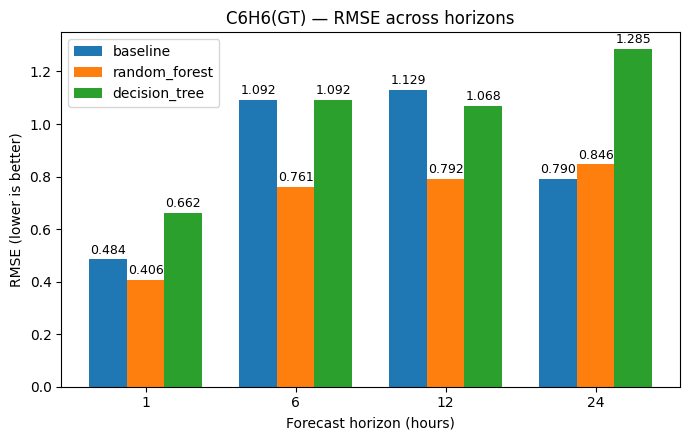

saved: /Users/zhangdonghuang/Desktop/COMP9417_Project/models/regression/results/figures/rmse_bars_C6H6GT.png


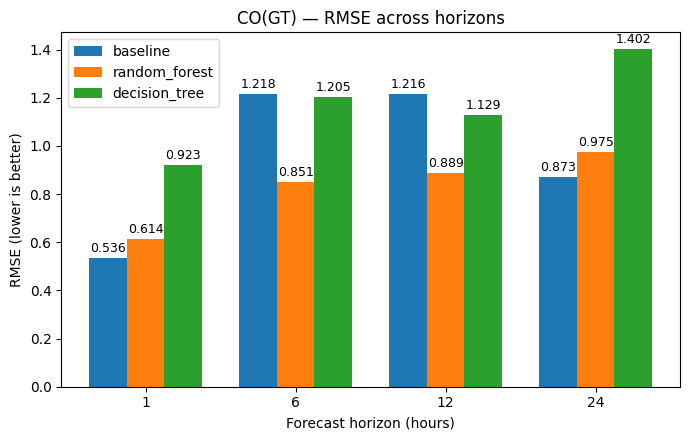

saved: /Users/zhangdonghuang/Desktop/COMP9417_Project/models/regression/results/figures/rmse_bars_COGT.png


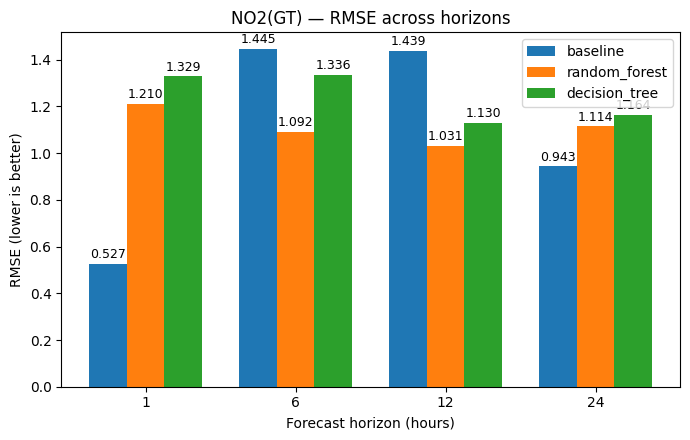

saved: /Users/zhangdonghuang/Desktop/COMP9417_Project/models/regression/results/figures/rmse_bars_NO2GT.png


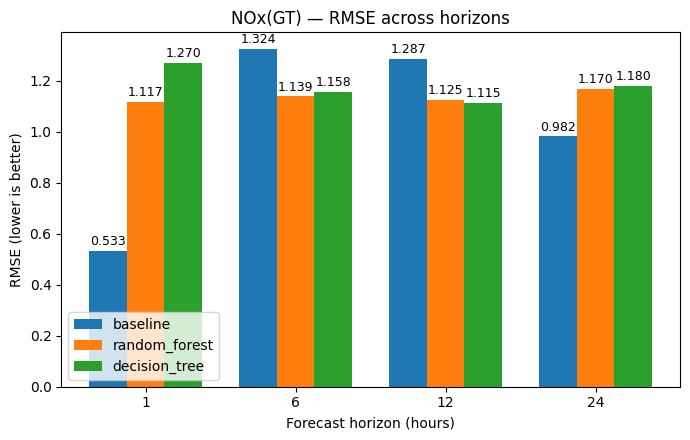

saved: /Users/zhangdonghuang/Desktop/COMP9417_Project/models/regression/results/figures/rmse_bars_NOxGT.png


In [38]:
# === Plot RMSE bars: Baseline vs RF vs DT for each pollutant ===
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

RES_DIR = Path("/Users/zhangdonghuang/Desktop/COMP9417_Project/models/regression/results")
FIG_DIR = RES_DIR / "figures"
FIG_DIR.mkdir(parents=True, exist_ok=True)

wide = pd.read_csv(RES_DIR / "rmse_wide_rf_dt_baseline.csv")


order = [1, 6, 12, 24]
wide["horizon_h"] = pd.Categorical(wide["horizon_h"], categories=order, ordered=True)
wide = wide.sort_values(["pollutant", "horizon_h"])

def add_value_labels(ax):
    
    for p in ax.patches:
        h = p.get_height()
        ax.annotate(f"{h:.3f}", (p.get_x() + p.get_width()/2, h),
                    ha="center", va="bottom", fontsize=9, rotation=0, xytext=(0, 2), textcoords="offset points")

for pol, g in wide.groupby("pollutant", sort=False):
    x = g["horizon_h"].astype(int).tolist()
    w = 0.25

    fig, ax = plt.subplots(figsize=(7, 4.5))

    
    b1 = ax.bar([i - w for i in range(len(x))], g["rmse_baseline"].values, width=w, label="baseline")
    b2 = ax.bar([i        for i in range(len(x))], g["rmse_rf"].values,        width=w, label="random_forest")
    b3 = ax.bar([i + w    for i in range(len(x))], g["rmse_dt"].values,        width=w, label="decision_tree")

    ax.set_title(f"{pol} — RMSE across horizons")
    ax.set_xlabel("Forecast horizon (hours)")
    ax.set_ylabel("RMSE (lower is better)")
    ax.set_xticks(range(len(x)))
    ax.set_xticklabels([str(v) for v in x])
    ax.legend()

    add_value_labels(ax)
    fig.tight_layout()

    out_path = FIG_DIR / f"rmse_bars_{pol.replace('(', '').replace(')', '').replace('/', '_')}.png"
    plt.savefig(out_path, dpi=180)
    plt.show()
    print("saved:", out_path)

In [40]:
import os
print(os.getcwd())

/Users/zhangdonghuang/Desktop/COMP9417
